In [1]:
import tensorflow as tf
#tfkl = tf.keras.layers
#import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm

In [2]:
from src.MI_estimators import VBMI

In [3]:
def sample_correlated_gaussian(rho=0.5, dim=20, n=1, batch_size=128):
  """Generate samples from a correlated Gaussian distribution."""
  x, eps = tf.split(tf.random.normal((batch_size, 2 * dim, n)), 2, axis=1)
  y = rho * x + tf.sqrt(tf.cast(1. - rho**2, tf.float32)) * eps
  return x, y


def rho_to_mi(dim, rho):
  return -0.5 * np.log(1-rho**2) * dim


def mi_to_rho(dim, mi):
  return np.sqrt(1-np.exp(-2.0 / dim * mi))


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-02-15 12:04:59.391368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-15 12:04:59.391510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


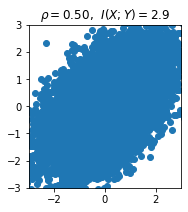

In [4]:
N_samples = 20000
batch_size = 256
L_E = 20
n = 1

plt.figure(figsize=(6, 3))
for i, rho in enumerate([0.5]):
  plt.subplot(1, 2, i + 1)
  x, y = sample_correlated_gaussian(
      batch_size=N_samples, dim=L_E, n=n, rho=rho)
  exact_mi = n * rho_to_mi(L_E, rho)

  plt.scatter(x[:, 0], y[:, 0])
  plt.title(r'$\rho=%.2f$,  $I(X; Y)=%.1f$' % (rho, exact_mi))
  plt.xlim(-3, 3)
  plt.ylim(-3, 3)


In [8]:
input_shapes = [(L_E, n), (L_E, n)]

vbmi = VBMI(batch_size, input_shapes=input_shapes, layers=2, embed_dim=32, hidden_dim=64, activation='relu',
            shuffle=100, learning_rate=5e-3, iterations=250, use_dropout=True, dropout_rate=0.3)


  0%|          | 0/19531 [00:00<?, ?it/s]

(-0.05, 3.16450279696959)

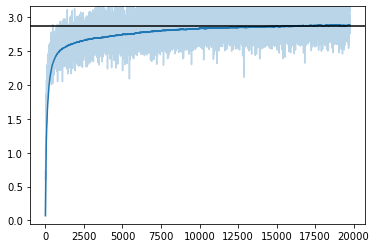

In [9]:
mis = vbmi.InfoNCE(x, y)

EMA_SPAN = 500
mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
p1 = plt.plot(mis, alpha=0.3)[0]
plt.plot(mis_smooth, c=p1.get_color())
plt.axhline(y=exact_mi, c='k', linestyle='-')
#plt.axhline(1 + np.log(batch_size) - 1,
#            c='k', linestyle='--', label=r'1 + log(K/$\alpha$)')
plt.ylim([-0.05, 1.1 * exact_mi])
